In [1]:
import torch
from transformers import AutoModelForCausalLM, AutoTokenizer, BitsAndBytesConfig
from datasets import load_dataset
import os
import json
import re
import random
import csv
# install bitsandbytes and restart

In [2]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [3]:
def load_json_from_drive(file_path):
    with open(file_path, 'r') as f:
        data = json.load(f)
    return data

tomi = load_json_from_drive("/content/drive/MyDrive/SEF/Data/ToMi/tomi_all.json")
bigtom = load_json_from_drive("/content/drive/MyDrive/SEF/Data/BigToM/bigtom_all.json")

In [4]:
model_id = "mistralai/Mistral-7B-v0.1"
tokenizer = AutoTokenizer.from_pretrained(model_id, padding=True, truncation=True, model_max_length=512)
tokenizer.padding_side = "right"
tokenizer.truncation_side = "right"

if tokenizer.pad_token is None:
    tokenizer.pad_token = tokenizer.eos_token


bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=torch.float16,
    bnb_4bit_use_double_quant=True,
)

model = AutoModelForCausalLM.from_pretrained(
    model_id,
    device_map="auto",
    quantization_config=bnb_config,
    dtype=torch.float16,
)
model.eval()

tokenizer_config.json:   0%|          | 0.00/996 [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/493k [00:00<?, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/414 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/571 [00:00<?, ?B/s]

model.safetensors.index.json: 0.00B [00:00, ?B/s]

Fetching 2 files:   0%|          | 0/2 [00:00<?, ?it/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/9.94G [00:00<?, ?B/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/4.54G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

MistralForCausalLM(
  (model): MistralModel(
    (embed_tokens): Embedding(32000, 4096)
    (layers): ModuleList(
      (0-31): 32 x MistralDecoderLayer(
        (self_attn): MistralAttention(
          (q_proj): Linear4bit(in_features=4096, out_features=4096, bias=False)
          (k_proj): Linear4bit(in_features=4096, out_features=1024, bias=False)
          (v_proj): Linear4bit(in_features=4096, out_features=1024, bias=False)
          (o_proj): Linear4bit(in_features=4096, out_features=4096, bias=False)
        )
        (mlp): MistralMLP(
          (gate_proj): Linear4bit(in_features=4096, out_features=14336, bias=False)
          (up_proj): Linear4bit(in_features=4096, out_features=14336, bias=False)
          (down_proj): Linear4bit(in_features=14336, out_features=4096, bias=False)
          (act_fn): SiLUActivation()
        )
        (input_layernorm): MistralRMSNorm((4096,), eps=1e-05)
        (post_attention_layernorm): MistralRMSNorm((4096,), eps=1e-05)
      )
    )
    (n

# Intervention with Forward Hooks

In [5]:
import numpy as np
tomi_weights = np.load('/content/drive/MyDrive/SEF/Data/NumPy/phase_1_tomi_weights.npy')

In [6]:
class MLPIntervention:
  def __init__(self, model, layer_idx: int, w_hat, alpha: float, token_pos: int = -1):
    self.model = model
    self.layer_idx = layer_idx
    self.alpha = float(alpha)
    self.token_pos = token_pos
    self.handle = None

    if not isinstance(w_hat, torch.Tensor):
      w_hat = torch.tensor(w_hat)

    # Match dtype/device to the model
    # (For 4-bit models, activations are usually fp16/bf16; this is fine.)
    param = next(model.parameters())
    self.w_hat = w_hat.to(device=param.device, dtype=param.dtype)

    # sanity check: hidden size
    hidden_size = self.w_hat.numel()
    # try to infer model hidden size
    try:
      model_hidden = model.config.hidden_size
      if model_hidden != hidden_size:
        raise ValueError(f"w_hat dim {hidden_size} != model hidden_size {model_hidden}")
    except Exception:
      pass

  def _hook_fn(self, module, inputs, output):
    # output: (batch, seq_len, model_d)
    if not torch.is_tensor(output):
      return output

    # some models may return tuples
    if isinstance(output, tuple):
      out = output[0]
      rest = output[1:]
    else:
      out = output
      rest = None

    # Ensure we don't accidentally edit a view that breaks autograd (we're in no_grad anyway)
    # Also avoid in-place issues if output is not writable
    out = out.clone()

    t = self.token_pos
    # support negative indexing robustly
    if out.size(1) == 0:
      return output
    if t < 0:
      t = out.size(1) + t

    out[:, t, :] = out[:, t, :] + (self.alpha * self.w_hat)

    if rest is None:
      return out
    return (out, *rest)

  def __enter__(self):
    mlp = self.model.model.layers[self.layer_idx].mlp
    self.handle = mlp.register_forward_hook(self._hook_fn)
    return self

  def __exit__(self, exc_type, exc, tb):
    if self.handle is not None:
      self.handle.remove()
      self.handle = None

# Primary Metric

In [7]:
import re
from collections import defaultdict

# prompt formatting
def build_tomi_prompt(story, question, *, force_short_answer=True):
  if force_short_answer:
    return (
        f'Only respond with the answer from the following text. Text: "The traveler moved from the outskirts of London into the city center. Where is the traveller?" Answer: London\nText: "After years in Tokyo, he decided to move to the countryside. Where did he originally live?" Answer: Tokyo\nText: "{story} {question}" Answer:'
    )
  else:
    return f"{story}\n{question}"

In [8]:
_LOCATION_RE = re.compile(
    r"(?:Answer\s*:?\s*)?([A-Za-z_]+)\b", re.IGNORECASE
)

def extract_location(text):
  text = text.strip()
  toks = re.findall(r"[A-Za-z_]+", text)
  return toks[0].lower() if toks else ""

In [9]:
def generate_location_answer(
    model,
    tokenizer,
    prompt,
    *,
    max_new_tokens=8,
    model_max_length=512,
):
  inputs = tokenizer(prompt, return_tensors="pt",
                     truncation=True,
                     max_length=model_max_length,
                     padding=False,).to(model.device)
  with torch.no_grad():
    out_ids = model.generate(
        **inputs, do_sample=False, temperature=1.0,
        max_new_tokens=max_new_tokens, num_beams=1,
        pad_token_id=tokenizer.eos_token_id,
        eos_token_id=tokenizer.eos_token_id,
    )
  decoded = tokenizer.decode(out_ids[0], skip_special_tokens=True)

  prefix = tokenizer.decode(inputs["input_ids"][0], skip_special_tokens=True)
  if decoded.startswith(prefix):
    gen_part = decoded[len(prefix):].strip()
  else:
    gen_part = decoded.strip()

  loc = extract_location(gen_part)
  return gen_part, loc


In [10]:
def evaluate_intervention_accuracy(
    model, tokenizer, examples, tomi_weights, *, layer_idx=17,
    alphas=(-5,-2,-0,2,5), max_new_tokens=8, model_max_length=512,
    force_short_answer=True,
):
  results = {alpha: {"correct": 0, "total": 0, "samples": []} for alpha in alphas}

  w = np.asarray(tomi_weights, dtype=np.float32)
  w = w / (np.linalg.norm(w) + 1e-8)

  for ex_i, ex in enumerate(examples):
    story_lines = ex["story"]
    question = ex["question"]
    gold = ex['answer'].strip().lower()
    prompt = build_tomi_prompt(story_lines, question,
                               force_short_answer=force_short_answer)

    for alpha in alphas:
      if alpha == 0:
        gen_text, pred = generate_location_answer(
            model, tokenizer, prompt,
            max_new_tokens=max_new_tokens, model_max_length=model_max_length,
        )
      else:
        with MLPIntervention(
            model, layer_idx=layer_idx, w_hat=w, alpha=float(alpha),
            token_pos=-1,
        ):
          gen_text, pred = generate_location_answer(
              model, tokenizer, prompt,
              max_new_tokens=max_new_tokens,
              model_max_length=model_max_length,
          )
      is_correct = (pred == gold)
      results[alpha]["correct"] += int(is_correct)
      results[alpha]["total"] += 1

      if ex_i < 10:
        results[alpha]['samples'].append({
            "gold": gold,
            "pred": pred,
            "gen": gen_text,
            "question": question,
        })
  acc = {alpha: (results[alpha]['correct'] / max(1, results[alpha]['total']))
  for alpha in alphas}

  return acc, results

def print_accuracy_table(acc):
  print("\nAccuracy vs intervention strength a")
  print("--------------------------------")
  for a in sorted(acc.keys()):
    print(f"a = {a:>4}: accuracy = {acc[a]}")

In [11]:
alphas = (-5, -2, 0, 2, 5)

acc, raw = evaluate_intervention_accuracy(
    model=model, tokenizer=tokenizer,
    examples=tomi,
    tomi_weights=tomi_weights, layer_idx=17, alphas = alphas,
    max_new_tokens=8, model_max_length=512,
    force_short_answer=True,
)

print_accuracy_table(acc)


Accuracy vs intervention strength a
--------------------------------
a =   -5: accuracy = 0.04
a =   -2: accuracy = 0.585
a =    0: accuracy = 0.825
a =    2: accuracy = 0.775
a =    5: accuracy = 0.6


In [12]:
alphas2 = (-3, -2, -1, 0, +1, +2, +3)

acc2, raw2 = evaluate_intervention_accuracy(
    model=model, tokenizer=tokenizer,
    examples=tomi,
    tomi_weights=tomi_weights, layer_idx=17, alphas = alphas2,
    max_new_tokens=8, model_max_length=512,
    force_short_answer=True,
)

print_accuracy_table(acc2)


Accuracy vs intervention strength a
--------------------------------
a =   -3: accuracy = 0.355
a =   -2: accuracy = 0.585
a =   -1: accuracy = 0.795
a =    0: accuracy = 0.825
a =    1: accuracy = 0.78
a =    2: accuracy = 0.775
a =    3: accuracy = 0.71


In [13]:
alphas3 = (-0.5, -0.25, -0.1, 0, +0.1, +0.25, +0.5)

acc3, raw3 = evaluate_intervention_accuracy(
    model=model, tokenizer=tokenizer,
    examples=tomi,
    tomi_weights=tomi_weights, layer_idx=17, alphas = alphas3,
    max_new_tokens=8, model_max_length=512,
    force_short_answer=True,
)

print_accuracy_table(acc3)


Accuracy vs intervention strength a
--------------------------------
a = -0.5: accuracy = 0.82
a = -0.25: accuracy = 0.83
a = -0.1: accuracy = 0.835
a =    0: accuracy = 0.825
a =  0.1: accuracy = 0.825
a = 0.25: accuracy = 0.815
a =  0.5: accuracy = 0.8


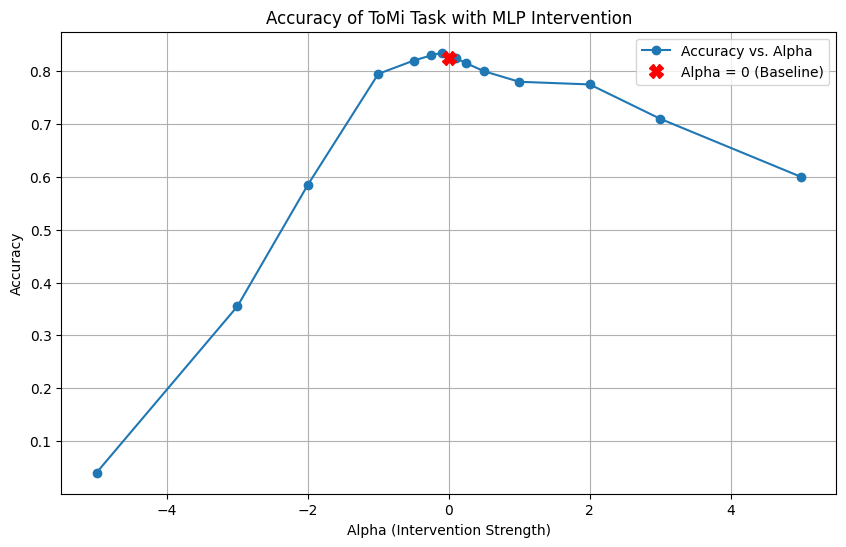

In [19]:
import matplotlib.pyplot as plt

# Combine all accuracy results into a single dictionary
all_accuracies = {}
all_accuracies.update(acc)
all_accuracies.update(acc2)
all_accuracies.update(acc3)

# Sort the alphas and their corresponding accuracies
sorted_alphas = sorted(all_accuracies.keys())
sorted_accuracies = [all_accuracies[alpha] for alpha in sorted_alphas]

# Create the line plot
plt.figure(figsize=(10, 6))
plt.plot(sorted_alphas, sorted_accuracies, marker='o', linestyle='-', label='Accuracy vs. Alpha')

# Add a marker at alpha = 0
if 0 in all_accuracies:
    plt.plot(0, all_accuracies[0], 'X', markersize=10, color='red', label='Alpha = 0 (Baseline)')

# Add labels and title
plt.xlabel('Alpha (Intervention Strength)')
plt.ylabel('Accuracy')
plt.title('Accuracy of ToMi Task with MLP Intervention')
plt.grid(True)
plt.legend()
plt.show()

In [29]:
# random activation interventions (control)

def make_random_unit_vector_like(w, seed=0):
    rng = np.random.default_rng(seed)
    w = np.asarray(w, dtype=np.float32)
    r = rng.standard_normal(size=w.shape).astype(np.float32)
    r /= (np.linalg.norm(r) + 1e-8)
    return r

random_weights = make_random_unit_vector_like(tomi_weights, seed=123)

acc_rand, raw_rand = evaluate_intervention_accuracy(
    model=model,
    tokenizer=tokenizer,
    examples=tomi,
    tomi_weights=random_weights,   # <-- random direction
    layer_idx=17,                  # same layer as main experiment
    alphas=(-3, -2, -1, 0, +1, +2, +3),
    max_new_tokens=8,
    model_max_length=512,
    force_short_answer=True,
)

print("Random direction control (layer 17):")
print_accuracy_table(acc_rand)

Random direction control (layer 17):

Accuracy vs intervention strength a
--------------------------------
a =   -3: accuracy = 0.75
a =   -2: accuracy = 0.775
a =   -1: accuracy = 0.815
a =    0: accuracy = 0.825
a =    1: accuracy = 0.82
a =    2: accuracy = 0.8
a =    3: accuracy = 0.755


In [30]:
# wrong layer activation intervention
acc_wrong_early, _ = evaluate_intervention_accuracy(
    model=model,
    tokenizer=tokenizer,
    examples=tomi,
    tomi_weights=tomi_weights,   # <-- same direction
    layer_idx=3,                 # <-- wrong/early layer
    alphas=(-3, -2, -1, 0, +1, +2, +3),
    max_new_tokens=8,
    model_max_length=512,
    force_short_answer=True,
)

print("Wrong-layer control (layer 3, ToMi vector):")
print_accuracy_table(acc_wrong_early)


acc_wrong_late, _ = evaluate_intervention_accuracy(
    model=model,
    tokenizer=tokenizer,
    examples=tomi,
    tomi_weights=tomi_weights,
    layer_idx=28,                # <-- wrong/late layer (example)
    alphas=(-2, -1, -0.5, 0, 0.5, 1, 2),
    max_new_tokens=8,
    model_max_length=512,
    force_short_answer=True,
)

print("Wrong-layer control (layer 28, ToMi vector):")
print_accuracy_table(acc_wrong_late)


Wrong-layer control (layer 3, ToMi vector):

Accuracy vs intervention strength a
--------------------------------
a =   -3: accuracy = 0.0
a =   -2: accuracy = 0.21
a =   -1: accuracy = 0.685
a =    0: accuracy = 0.825
a =    1: accuracy = 0.76
a =    2: accuracy = 0.465
a =    3: accuracy = 0.18


ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.


KeyboardInterrupt

